In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=ab4fb63b5e311788348d19dfc7b9cd31ee2119363c441c0c13546008f353d2d1
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [2]:
"""
To evaluate the equitable prediction of transplant survival outcomes,
we use the concordance index (C-index) between a series of event
times and a predicted score across each race group.
 
It represents the global assessment of the model discrimination power:
this is the model’s ability to correctly provide a reliable ranking
of the survival times based on the individual risk scores.
 
The concordance index is a value between 0 and 1 where:
 
0.5 is the expected result from random predictions,
1.0 is perfect concordance (with no censoring, otherwise <1.0),
0.0 is perfect anti-concordance (with no censoring, otherwise >0.0)

"""

import pandas as pd
import pandas.api.types
import numpy as np
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = {'prediction': {0: 1.0, 1: 0.0, 2: 1.0}}
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred.insert(0, row_id_column_name, range(len(y_pred)))
    >>> y_true = { 'efs': {0: 1.0, 1: 0.0, 2: 0.0}, 'efs_time': {0: 25.1234,1: 250.1234,2: 2500.1234}, 'race_group': {0: 'race_group_1', 1: 'race_group_1', 2: 'race_group_1'}}
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true.insert(0, row_id_column_name, range(len(y_true)))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.75
    """
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
print("Test shape:", test.shape )


train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
print("Train shape:",train.shape)

Test shape: (3, 58)
Train shape: (28800, 60)


In [5]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [6]:
test.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


In [7]:
train.describe()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time
count,28800.000000,24180.000000,22971.000000,25530.000000,23516.000000,21637.000000,23601.000000,24603.000000,26000.000000,26157.000000,24606.000000,28800.000000,24499.000000,26992.000000,26235.000000,28800.000000,26410.000000,24712.00000,28323.000000,27930.00000,25147.000000,25448.000000,23736.000000,28800.000000,28800.000000
mean,14399.500000,1.764516,6.876801,5.143322,5.109202,8.617230,1.736876,5.160346,1.757808,1.715296,1.773795,2015.179444,1.703743,42.511591,1.719916,38.663162,1.709087,1.69962,1.702327,83.83208,6.903448,1.707128,8.664687,0.539306,23.237678
std,8313.988213,0.431941,1.564313,1.207757,1.214162,1.905125,0.447687,1.203240,0.435453,0.451282,0.427130,3.153914,0.462213,15.251434,0.454449,21.147581,0.458259,0.46518,1.994443,11.02884,1.565017,0.461179,1.882746,0.498461,24.799748
min,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,0.000000,2008.000000,0.000000,18.010000,0.000000,0.044000,0.000000,0.00000,0.000000,40.00000,2.000000,0.000000,4.000000,0.000000,0.333000
25%,7199.750000,2.000000,6.000000,4.000000,4.000000,7.000000,1.000000,4.000000,2.000000,1.000000,2.000000,2013.000000,1.000000,28.447000,1.000000,19.539000,1.000000,1.00000,0.000000,70.00000,6.000000,1.000000,7.000000,0.000000,5.619750
50%,14399.500000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2016.000000,2.000000,40.063000,2.000000,41.006000,2.000000,2.00000,1.000000,90.00000,8.000000,2.000000,10.000000,1.000000,9.796500
75%,21599.250000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2018.000000,2.000000,56.131500,2.000000,55.965250,2.000000,2.00000,2.000000,90.00000,8.000000,2.000000,10.000000,1.000000,35.100000
max,28799.000000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2020.000000,2.000000,84.800000,2.000000,73.726000,2.000000,2.00000,10.000000,100.00000,8.000000,2.000000,10.000000,1.000000,156.819000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [9]:
train[['efs', 'efs_time']]

,efs,efs_time
0,0.0,42.356
1,1.0,4.672
2,0.0,19.793
3,0.0,102.349
4,0.0,16.223
...,...,...
28795,0.0,18.633
28796,1.0,4.892
28797,0.0,23.157
28798,0.0,52.351


In [10]:
max(train['efs_time'])

156.819

In [11]:
train['dri_score'].unique()

array(['N/A - non-malignant indication', 'Intermediate', 'High', 'Low',
       'N/A - disease not classifiable', 'N/A - pediatric',
       'TBD cytogenetics',
       'Intermediate - TED AML case <missing cytogenetics', nan,
       'High - TED AML case <missing cytogenetics', 'Very high',
       'Missing disease status'], dtype=object)

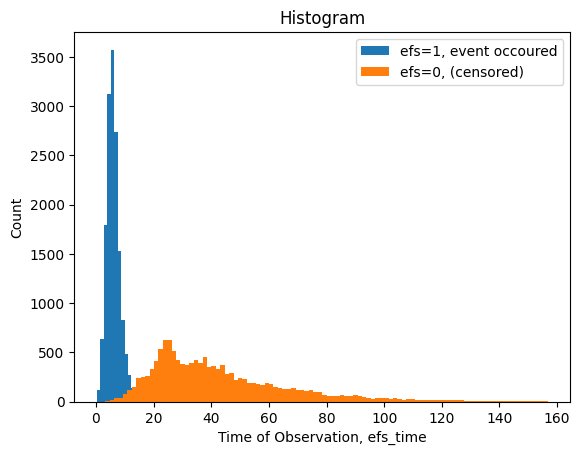

In [12]:
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, event occoured")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, (censored)")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Count")
plt.title("Histogram")
plt.legend()
plt.show()

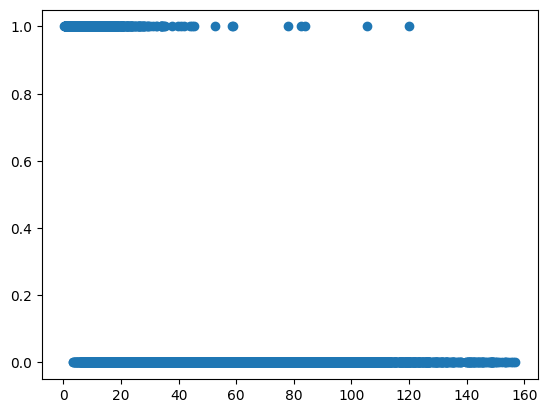

In [13]:
plt.scatter(train['efs_time'], train['efs'])
plt.show()

In [14]:
from lifelines import KaplanMeierFitter

def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    """
    Transform using survival probability estimates
    """
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y

In [15]:
train['y'] = transform_survival_probability(train, 'efs_time', 'efs')

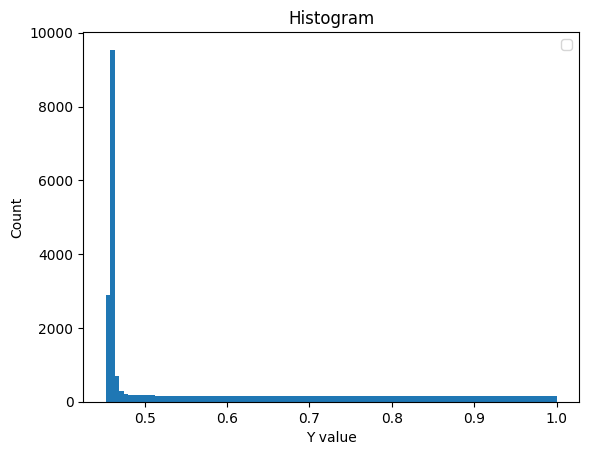

In [16]:
plt.hist(train['y'],bins=100)
plt.xlabel("Y value")
plt.ylabel("Count")
plt.title("Histogram")
plt.legend()
plt.show()

In [17]:
to_rmv =['ID', 'efs', 'efs_time', 'y']
features = [col for col in train.columns if not col in to_rmv]
target = 'y'
print(f'There are {len(features)} features')

There are 57 features


In [18]:
cat = [c for c in features if train[c].dtype == 'object']
print(f'There are {len(cat)} catagorial features')

There are 35 catagorial features


In [19]:
train[cat].columns

Index(['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status',
       'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe',
       'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab',
       'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity',
       'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe',
       'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match',
       'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'cardiac', 'pulm_moderate'],
      dtype='object')

In [20]:
num = [c for c in features if train[c].dtype != 'object']
print(f'There are {len(num)} numerical features')

There are 22 numerical features


# 1st try: apply label encoder for all cat features

In [59]:
# from sklearn.preprocessing import LabelEncoder

# encoder = LabelEncoder()

# # Apply LabelEncoder only on the training set and then use it on the test set
# for column in categorical_columns:
#     # Fit the encoder on the training data
#     encoder.fit(train[column].astype(str))
    
#     # Transform both the training and test data using the same encoder
#     train[column] = encoder.transform(train[column].astype(str))
#     test[column] = encoder.transform(test[column].astype(str))  # Apply transformation on test set as well

#     # Ensure the encoded values are integers
#     train[column] = train[column].astype('int32')
#     test[column] = test[column].astype('int32')

#     # Optionally, convert to 'category' dtype if needed for memory efficiency
#     train[column] = train[column].astype('category')
#     test[column] = test[column].astype('category')

# test = test.drop(columns='y')

In [60]:
# train.head()

In [61]:
# train[features].isnull().sum()

In [62]:
# import warnings
# warnings.filterwarnings("ignore")

# def convert_64_to_32(df, num_features):
#     for c in num_features:
#         if df[c].dtype == 'float64':
#             df[c] = df[c].astype('float32')
#         else:
#             df[c] = df[c].astype('int32')
#     return df

# train = convert_64_to_32(train, num)
# test = convert_64_to_32(test, num)

# Feature eng

In [21]:
for c in cat:
    train[c].fillna('Missing', inplace=True)
    test[c].fillna('Missing', inplace=True)

In [22]:
def convert_64_to_32(df, num_features):
    for c in num_features:
        if df[c].dtype == 'float64':
            df[c] = df[c].astype('float32')
        else:
            df[c] = df[c].astype('int32')
    return df

train = convert_64_to_32(train, num)
test = convert_64_to_32(test, num)

In [23]:
def clean_columns(df):

    value_mappings = {
        'cmv_status': {
            '+/+': 'Positive_Positive',
            '+/-': 'Positive_Negative',
            '-/+': 'Negative_Positive',
            '-/-': 'Negative_Negative'
        },
        'tbi_status': {
            'No TBI': 'No_Total_Body_Irradiation',
            'TBI + Cy +- Other': 'TBI_with_Cyclophosphamide_and_Other',
            'TBI +- Other, <=cGy': 'TBI_with_Other_Low_Dose',
            'TBI +- Other, >cGy': 'TBI_with_Other_High_Dose',
            'TBI +- Other, -cGy, single': 'TBI_with_Other_Single_Dose',
            'TBI +- Other, unknown dose': 'TBI_with_Other_Unknown_Dose',
            'TBI +- Other, -cGy, unknown dose': 'TBI_with_Other_Unknown_Dose',
            'TBI +- Other, -cGy, fractionated': 'TBI_with_Other_Fractionated_Dose'
        },
        'dri_score': {
            'Intermediate': 'Intermediate_Risk',
            'N/A - pediatric': 'Not_Applicable_Pediatric',
            'High': 'High_Risk',
            'N/A - non-malignant indication': 'Not_Applicable_Non_Malignant',
            'TBD cytogenetics': 'To_Be_Determined_Cytogenetics',
            'Low': 'Low_Risk',
            'High - TED AML case <missing cytogenetics': 'High_Risk_TED_AML_Missing_Cytogenetics',
            'Intermediate - TED AML case <missing cytogenetics': 'Intermediate_Risk_TED_AML_Missing_Cytogenetics',
            'N/A - disease not classifiable': 'Not_Applicable_Disease_Not_Classifiable',
            'Very high': 'Very_High_Risk',
            'Missing disease status': 'Missing'
        },
        'tce_imm_match': {
            'P/P': 'Perfect_Perfect',
            'G/G': 'Good_Good',
            'H/H': 'Heterozygous_Heterozygous',
            'G/B': 'Good_Bad',
            'H/B': 'Heterozygous_Bad',
            'P/H': 'Perfect_Heterozygous',
            'P/B': 'Perfect_Bad',
            'P/G': 'Perfect_Good'
        },
        'gvhd_proph': {
            'FK+ MMF +- others': 'Tacrolimus_MMF_with_Others',
            'Cyclophosphamide alone': 'Cyclophosphamide_Alone',
            'FK+ MTX +- others(not MMF)': 'Tacrolimus_MTX_with_Others_Not_MMF',
            'Cyclophosphamide +- others': 'Cyclophosphamide_with_Others',
            'CSA + MMF +- others(not FK)': 'Cyclosporine_MMF_with_Others_Not_Tacrolimus',
            'FKalone': 'Tacrolimus_Alone',
            'Other GVHD Prophylaxis': 'Other_GVHD_Prophylaxis',
            'TDEPLETION alone': 'TCell_Depletion_Alone',
            'TDEPLETION +- other': 'TCell_Depletion_with_Others',
            'No GvHD Prophylaxis': 'No_GVHD_Prophylaxis',
            'CDselect alone': 'CD_Selection_Alone',
            'CSA + MTX +- others(not MMF,FK)': 'Cyclosporine_MTX_with_Others_Not_MMF_Tacrolimus',
            'CSA alone': 'Cyclosporine_Alone',
            'Parent Q = yes, but no agent': 'Parent_Yes_No_Agent',
            'CDselect +- other': 'CD_Selection_with_Others',
            'CSA +- others(not FK,MMF,MTX)': 'Cyclosporine_with_Others_Not_Tacrolimus_MMF_MTX',
            'FK+- others(not MMF,MTX)': 'Tacrolimus_with_Others_Not_MMF_MTX'
        }
    }

    for col, mappings in value_mappings.items():
        if col in df.columns:
            df[col] = df[col].astype(str).map(mappings).fillna(df[col])

    return df

def clean_space(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].apply(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)
    return df

def clean_not_done(df):
    df = df.map(lambda x: 'Missing' if x == 'Not done' else x)
    return df

def clean_not_tested(df):
    df = df.map(lambda x: 'Missing' if x == 'Not tested' else x)
    return df

def clean_dri_score(score):
    if isinstance(score, str) and 'Missing disease status' in score:
        return 'Missing'
    return score

def clean_conditioning_intensity(score):
    if isinstance(score, str) and 'No drugs reported' in score:
        return 'Missing'
    return score

In [24]:
train = clean_columns(train)
test = clean_columns(test)

train = clean_not_done(train)
test = clean_not_done(test)

train = clean_not_tested(train)
test = clean_not_tested(test)

train['dri_score'] = train['dri_score'].apply(clean_dri_score)
test['dri_score'] = test['dri_score'].apply(clean_dri_score)

train['conditioning_intensity'] = train['conditioning_intensity'].apply(clean_conditioning_intensity)
test['conditioning_intensity'] = test['conditioning_intensity'].apply(clean_conditioning_intensity)

train = clean_space(train)
test = clean_space(test)


# LightGBM

In [25]:
from sklearn.preprocessing import LabelEncoder


def encode_features_lgb(train, test, cat, num):
    train = train.copy()
    test = test.copy()
    
    for c in cat:
        encoder = LabelEncoder()

        # Fit and transform the training data
        train[c] = train[c].astype(str)
        train[c] = encoder.fit_transform(train[c])
        train[c] = train[c].astype('int32').astype('category')

        # Transform the test data using the encoder fitted on the training data
        test[c] = test[c].astype(str)
        test[c] = encoder.transform(test[c])
        test[c] = test[c].astype('int32').astype('category')

    return train, test

train_lgb, test_lgb = encode_features_lgb(train, test, cat, num)

In [26]:
model_params = {
    'max_depth': 3,
    'colsample_bytree': 0.4,
    'learning_rate': 0.02, 
    'objective': "regression", 
    'verbose': -1, 
}

In [28]:
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import *
import lightgbm as lgb
from lightgbm import LGBMRegressor

def train_lgbm(train, test, model_params, features, cat_features, target):

    fix_params = {
        'device': "gpu",
        'cat_features': cat,
        'n_estimators': 10000,
        'objective': 'regression',
        'early_stopping_rounds':20
    }
    model_params.update(fix_params)
    
    FOLDS = 10
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
    oof_lgb = np.zeros(len(train))
    pred_lgb = np.zeros(len(test))

    print('Training model with the followin parameters')
    for k, v in model_params.items():
        print(f'{k} : {v}')

    for i, (t_idx, v_idx) in enumerate(kf.split(train)):

        X_train = train.iloc[t_idx][features].copy()
        y_train = train.iloc[t_idx][target]
        X_valid = train.iloc[v_idx][features].copy()
        y_valid = train.iloc[v_idx][target]
        X_test = test[features].copy()

        model_lgb = LGBMRegressor(**model_params)
        model_lgb.fit(
            X_train, np.log1p(y_train),
            eval_set=[(X_valid, np.log1p(y_valid))],
        )  
        
        y_valid_preds = np.expm1(model_lgb.predict(X_valid))
        oof_lgb[v_idx] = y_valid_preds
        pred_lgb += np.expm1(model_lgb.predict(X_test))

        
        fold_rmse = mean_squared_error(y_valid, y_valid_preds, squared=False)
        print("#"*25)
        print(f"### Fold {i+1} \n")
        print(f"Fold {i+1} RMSE: {fold_rmse}")
        print("#"*25)

    pred_lgb /= FOLDS

    return model_lgb, oof_lgb, pred_lgb


In [29]:
model_lgb, oof_lgb, pred_lgb = train_lgbm(
    train=train_lgb, 
    test=test_lgb,
    model_params=model_params,
    features=features,
    cat_features=cat,
    target=target
)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb
m = score(y_true, y_pred, "ID")
print(f"\nOverall CV for KaplanMeier =", m)

# Overall CV for KaplanMeier = 0.672177282559423

Training model with the followin parameters
max_depth : 3
colsample_bytree : 0.4
learning_rate : 0.02
objective : regression
verbose : -1
device : gpu
cat_features : ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']
n_estimators : 10000
early_stopping_rounds : 20
#########################
### Fold 1 

Fold 1 RMSE: 0.15678668668802387
#########################
#########################
### Fold 2 

Fold 2 RMSE: 0.1534058413775572
#########################
#########################
### Fold 3 

Fold 3 RMSE: 0.1556846

In [ ]:
feature_importance = model_lgb.feature_importances_

# Get the feature names from the model (replace with actual feature names if needed)
feature_names = model_lgb.feature_name_

# Sort the feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Plotting
plt.figure(figsize=(10, 15))  # Increase the figure size for more room
plt.barh(range(len(feature_importance)), feature_importance[indices], align='center')
plt.yticks(range(len(feature_importance)), [feature_names[i] for i in indices], fontsize=10)  # Adjust font size for clarity
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importance from LightGBM Model', fontsize=10)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top

# Adjust layout for padding
plt.tight_layout(pad=1.0)

plt.show()

# XGBoost

In [ ]:
def encode_features_xgb(train, test, label_encode_features, one_hot_encode_features, features):

    # Label Encoding
    label_encoders = {}
    for feature in label_encode_features:
        encoder = LabelEncoder()
        train[feature] = train[feature].astype(str)
        train[feature] = encoder.fit_transform(train[feature])
        test[feature] = test[feature].astype(str)
        test[feature] = encoder.transform(test[feature])
        label_encoders[feature] = encoder

    # One-Hot Encoding
    train_one_hot = pd.get_dummies(train[one_hot_encode_features], prefix=one_hot_encode_features)
    test_one_hot = pd.get_dummies(test[one_hot_encode_features], prefix=one_hot_encode_features)

    train_one_hot, test_one_hot = train_one_hot.align(test_one_hot, join="outer", axis=1, fill_value=0)

    train_xgb = pd.concat([train, train_one_hot], axis=1)
    test_xgb = pd.concat([test, test_one_hot], axis=1)

    features_xgb = features.copy()
    features_xgb.extend(train_one_hot.columns)
    features_xgb = [f for f in features_xgb if f not in one_hot_encode_features]

    return train_xgb, test_xgb, features_xgb

In [ ]:
# Define features for label and one-hot encoding
label_encode_features = [
    "dri_score", "psych_disturb", "cyto_score", "diabetes", 
    "arrhythmia", "vent_hist", "renal_issue", "pulm_severe", 
    "cmv_status", "tce_imm_match", "rituximab", "cyto_score_detail", 
    "conditioning_intensity", "ethnicity", "obesity", "mrd_hct", 
    "in_vivo_tcd", "tce_match", "hepatic_severe", "prior_tumor", 
    "peptic_ulcer", "gvhd_proph", "rheum_issue", "sex_match", 
    "hepatic_mild", "tce_div_match", "donor_related", "melphalan_dose", 
    "cardiac", "pulm_moderate"
]

one_hot_encode_features = [
    "tbi_status", "graft_type", "prod_type", "prim_disease_hct", "race_group"
]

# Apply the encoding
train_xgb, test_xgb, features_xgb = encode_features_xgb(train, test, label_encode_features, one_hot_encode_features, features)


In [ ]:
model_params = {
    'device': "gpu",
    'max_depth': 3,
    'colsample_bytree': 0.4,
    'learning_rate': 0.02, 
    'objective': "regression", 
}

In [ ]:
from xgboost import XGBRegressor

def train_XGB(train, test, model_params, features, target):
    fix_params = {
        'objective': 'reg:squarederror',
        'n_estimators': 10000,
        'early_stopping_rounds': 20,
        'eval_metric': 'rmse',
        'enable_categorical': True
    }
    model_params.update(fix_params)

    FOLDS = 10
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    oof_xgb = np.zeros(len(train))
    pred_xgb = np.zeros(len(test))

    print('Training XGBoost model with the following parameters:')
    for k, v in model_params.items():
        print(f'{k} : {v}')

    for i, (t_idx, v_idx) in enumerate(kf.split(train)):
        X_train = train.iloc[t_idx][features].copy()
        y_train = train.iloc[t_idx][target]
        X_valid = train.iloc[v_idx][features].copy()
        y_valid = train.iloc[v_idx][target]
        X_test = test[features].copy()

        model_xgb = XGBRegressor(**model_params)
        model_xgb.fit(
            X_train, np.log1p(y_train),
            eval_set=[(X_valid, np.log1p(y_valid))],
            verbose=False
        )

        y_valid_preds = np.expm1(model_xgb.predict(X_valid))
        oof_xgb[v_idx] = y_valid_preds
        pred_xgb += np.expm1(model_xgb.predict(X_test))

        fold_rmse = mean_squared_error(y_valid, y_valid_preds, squared=False)
        print("#" * 25)
        print(f"### Fold {i+1} \n")
        print(f"Fold {i+1} RMSE: {fold_rmse}")
        print("#" * 25)

    pred_xgb /= FOLDS

    return model_xgb, oof_xgb, pred_xgb

In [ ]:
model_xgb, oof_xgb, pred_xgb = train_XGB(train_xgb, test_xgb, model_params, features_xgb, target)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb
m = score(y_true, y_pred, "ID")
print(f"\nOverall CV for KaplanMeier =", m)

# CatBoost

In [30]:
train_cat = train.copy()
test_cat = test.copy()

In [31]:
model_params = {
    'task_type': "GPU",  # Use GPU for training
    'depth': 3,  # Maximum depth of trees
    'learning_rate': 0.02, 
    'loss_function': 'RMSE',  # Regression loss function
    'verbose': -1,  # Suppress verbose output
}

In [32]:
from catboost import CatBoostRegressor

def train_CAT(train, test, model_params, features, cat_features, target):
    fix_params = {
        'iterations': 10000,
        'loss_function': 'RMSE',
        'early_stopping_rounds': 20,
    }
    model_params.update(fix_params)

    FOLDS = 10
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    oof_cat = np.zeros(len(train))
    pred_cat = np.zeros(len(test))

    print('Training model with the following parameters')
    for k, v in model_params.items():
        print(f'{k} : {v}')

    for i, (t_idx, v_idx) in enumerate(kf.split(train)):
        X_train = train.iloc[t_idx][features].copy()
        y_train = train.iloc[t_idx][target]
        X_valid = train.iloc[v_idx][features].copy()
        y_valid = train.iloc[v_idx][target]
        X_test = test[features].copy()


        model_cat = CatBoostRegressor(**model_params)
        model_cat.fit(
            X_train, np.log1p(y_train),
            cat_features=cat_features,
            eval_set=[(X_valid, np.log1p(y_valid))],
            verbose=False
        )

        y_valid_preds = np.expm1(model_cat.predict(X_valid))
        oof_cat[v_idx] = y_valid_preds
        pred_cat += np.expm1(model_cat.predict(X_test))

        fold_rmse = mean_squared_error(y_valid, y_valid_preds, squared=False)
        print("#" * 25)
        print(f"### Fold {i + 1} \n")
        print(f"Fold {i + 1} RMSE: {fold_rmse}")
        print("#" * 25)

    pred_cat /= FOLDS

    return model_cat, oof_cat, pred_cat


In [ ]:
model_cat, oof_cat, pred_cat = train_CAT(train_cat, test_cat, model_params, features, cat, target)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_cat
m = score(y_true, y_pred, "ID")
print(f"\nOverall CV for KaplanMeier =", m)

Training model with the following parameters
task_type : GPU
depth : 3
learning_rate : 0.02
loss_function : RMSE
verbose : -1
iterations : 10000
early_stopping_rounds : 20


# Hyperparameter tuning

### For LGBM

In [75]:
import optuna

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective_lgbm(trial, data=train[features], target=train[target]):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_idx, test_idx in kf.split(data):
        X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
        y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]


        param = {
            'device': "gpu",
            'max_depth': trial.suggest_int('max_depth', 2, 4),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'num_leaves': trial.suggest_int('num_leaves', 15, 100),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 50),
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'objective': 'regression',
            'boosting_type': 'gbdt',
            'verbosity': -1,
        }

        model = LGBMRegressor(**param)
        model.fit(
            X_train, np.log1p(y_train),
            eval_set=[(X_test, np.log1p(y_test))],
        )

        preds = np.expm1(model.predict(X_test))
        rmse = mean_squared_error(y_test, preds, squared=False)
        scores.append(rmse)

    return np.mean(scores)


def progress_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")


In [76]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective_lgbm, n_trials=100, callbacks=[progress_callback], n_jobs=-1)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

In [ ]:
model_params = study.best_trial.params
model_lgb, oof_lgb, pred_lgb = train_lgbm(train, test, model_params, features, cat, target)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb
m = score(y_true, y_pred, "ID")
print(f"\nOverall CV for KaplanMeier =", m)

In [ ]:
model_lgb_params = {
    'max_depth': 5,
    'learning_rate': 0.01,
    'colsample_bytree': 0.40481123886709114,
    'subsample': 0.7673666426617842,
    'num_leaves': 46,
    'min_child_samples': 34,
    'lambda_l1': 0.0032893870728708495,
    'lambda_l2': 1.5780171816002318e-06,
    'bagging_freq': 5,
    'cat_features': cat,
    'n_estimators': 5000,
    'objective': 'regression',
    'early_stopping_rounds': 20
}

### For XGB

In [ ]:
def objective_XGB(trial, data=train_xgb[features_xgb], target=train_xgb[target]):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_idx, test_idx in kf.split(data):
        X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
        y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]

        # Define hyperparameters
        param = {
            'tree_method': 'gpu_hist',  # Use GPU for faster training
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),  # L1 regularization
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),  # L2 regularization
            'gamma': trial.suggest_float('gamma', 0, 5.0),  # Minimum loss reduction to make a split
            'objective': 'reg:squarederror',  # Regression task
            'verbosity': 0,
        }

        model = XGBRegressor(**param, random_state=42)
        model.fit(
            X_train, np.log1p(y_train),
            eval_set=[(X_test, np.log1p(y_test))],
            verbose=False
        )


        preds = np.expm1(model.predict(X_test))
        rmse = mean_squared_error(y_test, preds, squared=False)
        scores.append(rmse)

    return np.mean(scores)


def progress_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")


In [ ]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective_XGB, n_trials=100, callbacks=[progress_callback], n_jobs=-1)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

In [ ]:
model_params = study.best_trial.params
model_xgb, oof_xgb, pred_xgb = train_XGB(train, test, model_params, features, target)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_xgb
m = score(y_true, y_pred, "ID")
print(f"\nOverall CV for KaplanMeier =", m)

In [ ]:
model_xgb_params = {
    "max_depth": 4,
    "learning_rate": 0.04448229559503708,
    "colsample_bytree": 0.5682579726601504,
    "subsample": 0.5090805638031732,
    "n_estimators": 10000,
    "min_child_weight": 7.672969708439665,
    "reg_alpha": 0.022452971107717497,
    "reg_lambda": 6.173763762997143e-05,
    "gamma": 0.002112726185005874,
    "objective": "reg:squarederror",
    "early_stopping_rounds": 20,
    "eval_metric": "rmse",
    "enable_categorical": True
}

### For CAT

In [ ]:
def objective_CAT(trial, data=train[features], target=train[target], cat_features=cat):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_idx, test_idx in kf.split(data):
        X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
        y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
        
        # model_params = {
        #     'task_type': "GPU",  # Use GPU for training
        #     'depth': 3,  # Maximum depth of trees
        #     'learning_rate': 0.02, 
        #     'loss_function': 'RMSE',  # Regression loss function
        #     'verbose': -1,  # Suppress verbose output
        # }
        # Define base parameters
        param = {
            'task_type': "GPU",
            'loss_function': 'RMSE',
            'depth': trial.suggest_int('depth', 3, 5),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'verbose': -1  # Suppress logs
        }

        # Create and train the model
        model_cat = CatBoostRegressor(**param)
        model_cat.fit(
            X_train, np.log1p(y_train),
            cat_features=cat_features,
            eval_set=[(X_test, np.log1p(y_test))],
            verbose=False  # Suppress evaluation logs
        )

        # Predictions and scoring
        preds = np.expm1(model_cat.predict(X_test))
        rmse = mean_squared_error(y_test, preds, squared=False)
        scores.append(rmse)

    return np.mean(scores)

# Submission

In [ ]:
# Still using only LGBM for submission. Trying to optimize XGB, CAT first

model_params = {
    'max_depth': 5,
    'learning_rate': 0.01,
    'colsample_bytree': 0.40481123886709114,
    'subsample': 0.7673666426617842,
    'num_leaves': 46,
    'min_child_samples': 34,
    'lambda_l1': 0.0032893870728708495,
    'lambda_l2': 1.5780171816002318e-06,
    'bagging_freq': 5,
    'cat_features': cat,
    'n_estimators': 5000,
    'objective': 'regression',
    'early_stopping_rounds': 20
}

model_lgb, oof_lgb, pred_lgb = train_lgbm(train, test, model_params)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_lgb
m = score(y_true, y_pred, "ID")
print(f"\nOverall CV for KaplanMeier =", m)


# Submission

In [ ]:
sample_submission = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')
submission = sample_submission.copy()
submission['prediction'] = pred_lgb
submission.to_csv('/kaggle/working/submission.csv', index=False)
submission